In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yaml
from glob import glob
import pathlib

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [2]:
log_dir = '/data/zhenyus/webcachesim/log'

In [60]:
def to_label(x):
    """
    what to put on legend
    """
    return yaml.dump(
        {k: x[k] for k in x.to_dict() if k not in {
            'cache_size', 
            'byte_hit_rate', 
            'object_hit_rate',
            'trace_file', 
            'n_warmup', 
            'n_early_stop',
            'task_id',
            'elapse',
            'uni_size',
        } and not pd.isnull(x[k])
        })

def to_id(x):
    """
    unique identifier
    """
    return str(yaml.dump(
        {k: x[k] for k in x if k not in {
            'byte_hit_rate', 
            'object_hit_rate',
            'task_id',
            'elapse',
        } and not pd.isnull(x[k])
        }))

    
def load_reports(log_dir):
    timestamps = glob(f'{log_dir}/*.res')
    timestamps = [pathlib.PurePosixPath(t).stem for t in timestamps]
    timestamps.sort()
    tasks = {}
    for t in timestamps:
        with open(f'{log_dir}/{t}.res') as f:
            res = yaml.load(f)
        res = {**res['res'], **res['task']}
        tasks[to_id(res)] = res
    tasks = [{'task_id': k, **v} for k, v in tasks.items()]
    df = pd.DataFrame(tasks)
#     df['task_id'] = df.apply(lambda x: to_id(x), axis='columns')
#     df = df.drop_duplicates(keep='last', subset=[
#         'task_id',
#     ])
    return df

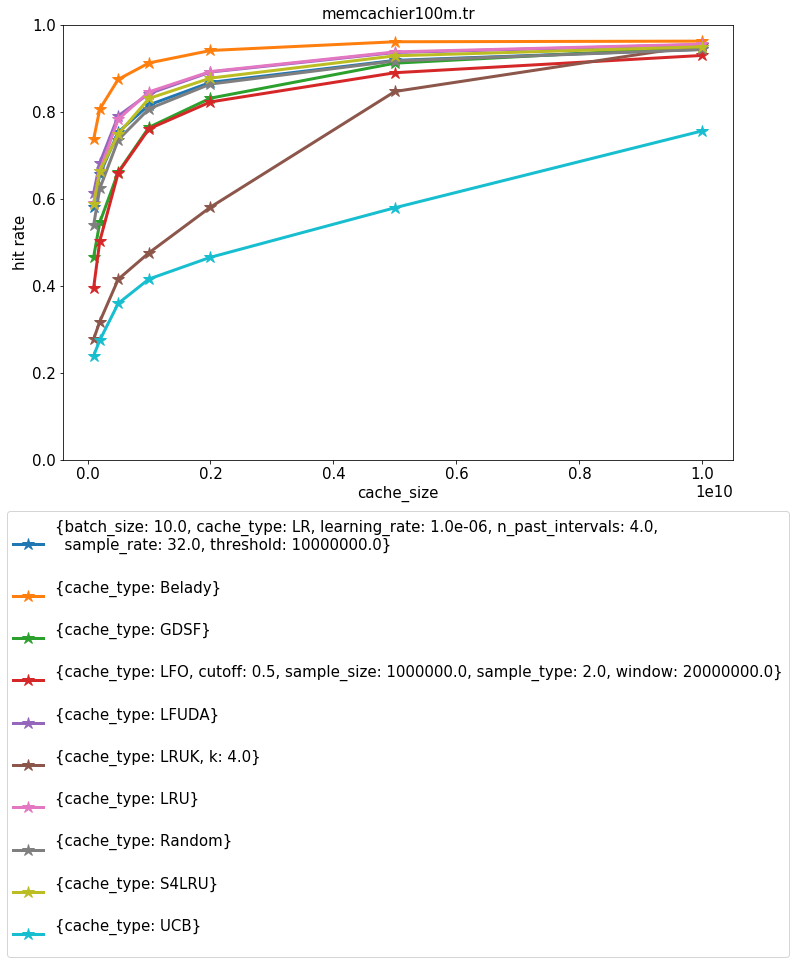

In [61]:
trace = 'memcachier100m.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
    & ((df.cache_type != "LFO") | (df.sample_size == 1000000))
    & (df.n_warmup == 20000000)
#     & (100000000 <= df.cache_size)
#     & (df.cache_size <= 10000000000)
#     & (df.n_warmup == 100000)
#     & (df.if_uni_size == False)
#     & (df.cache_capacity <= 30000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

df1 = df[filter_idx].copy()
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='*', markersize=12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.ylim([0, 1.])
plt.show()

In [62]:
df1[['byte_hit_rate', 'cache_size', 'cache_type']].pivot(index='cache_type', columns='cache_size', values='byte_hit_rate')

cache_size,100000000,200000000,500000000,1000000000,2000000000,5000000000,10000000000
cache_type,,,,,,,
Belady,0.736969,0.806162,0.874590,0.912224,0.940863,0.960923,0.962347
GDSF,0.466136,0.545382,0.661388,0.764268,0.831268,0.911669,0.948753
LFO,0.395237,0.502578,0.659692,0.760732,0.822553,0.889735,0.929513
LFUDA,0.613209,0.682362,0.790497,0.841701,0.891294,0.936179,0.954319
LR,0.581637,0.656547,0.752997,0.815698,0.867453,0.918095,0.943464
LRU,0.589578,0.664646,0.782874,0.845688,0.892424,0.937577,0.955269
LRUK,0.277189,0.317581,0.414798,0.475638,0.580614,0.846603,0.953896
Random,0.539380,0.623608,0.735535,0.806760,0.863662,0.916865,0.943160
S4LRU,0.588361,0.663465,0.748606,0.830589,0.877315,0.928560,0.949384


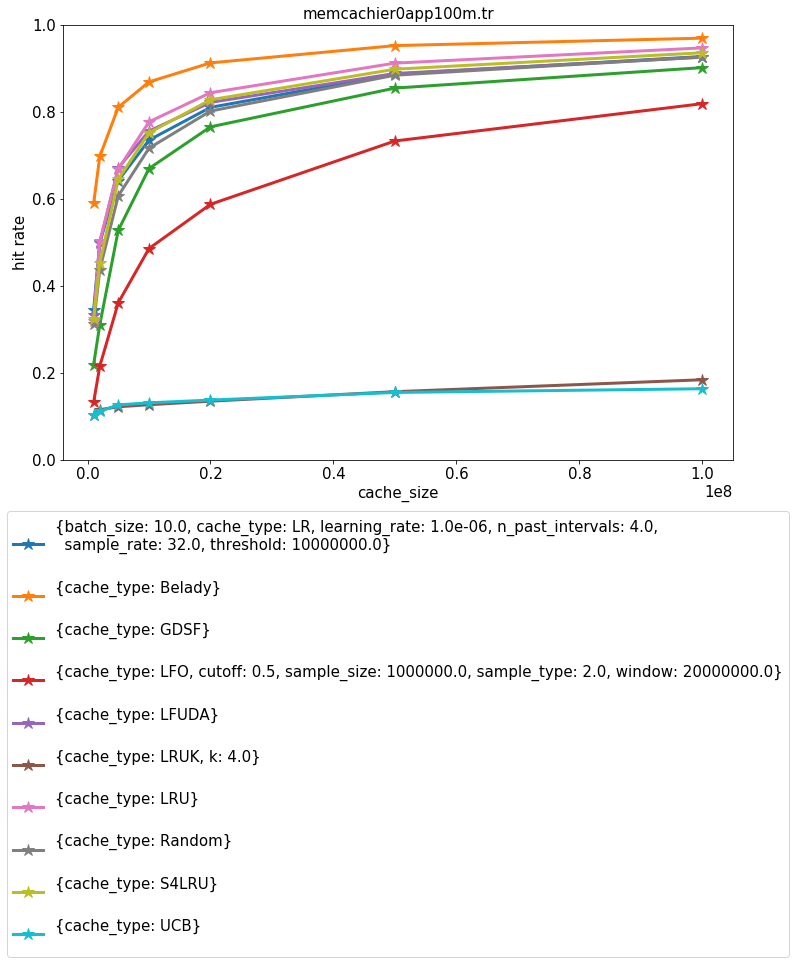

In [63]:
trace = 'memcachier0app100m.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & (1000000 <= df.cache_size)
#     & (df.cache_size <= 100000000)
    & ((df.cache_type != "LFO") | (df.sample_size == 1000000))
    & (df.n_warmup == 20000000)
#     & (df.n_warmup == 100000)
#     & (df.if_uni_size == False)
#     & (df.cache_capacity <= 30000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

df1 = df[filter_idx].copy()
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='*', markersize=12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.ylim([0, 1.])
plt.show()

In [64]:
df1[['byte_hit_rate', 'cache_size', 'cache_type']].pivot(index='cache_type', columns='cache_size', values='byte_hit_rate')

cache_size,1000000,2000000,5000000,10000000,20000000,50000000,100000000
cache_type,,,,,,,
Belady,0.589500,0.697257,0.810187,0.868597,0.912342,0.952094,0.969220
GDSF,0.218767,0.310392,0.527183,0.669373,0.765299,0.854383,0.901458
LFO,0.132132,0.214872,0.360570,0.485407,0.587161,0.732799,0.818593
LFUDA,0.331474,0.497517,0.670814,0.755510,0.821494,0.887941,0.925294
LR,0.344757,0.499575,0.641607,0.734731,0.810102,0.886501,0.927029
LRU,0.319090,0.502657,0.668103,0.776710,0.843780,0.911764,0.946817
LRUK,0.102640,0.114904,0.121555,0.126308,0.134450,0.156276,0.183719
Random,0.312300,0.437013,0.606482,0.716173,0.801585,0.884045,0.926062
S4LRU,0.322953,0.452682,0.644483,0.751519,0.827492,0.897825,0.935634
